<a href="https://colab.research.google.com/github/C-Gibson20/lstm-strategy/blob/main/LSTM_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor

In [52]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
CONFIG = {
    'ticker': 'MRK',
    'start_date': '2002-01-01',
    'end_date': '2022-01-01',
    'test_size': 0.2,
    'train_size': 0.6,
    'time_step': 10,
    'stride': 63,
    'lstm_units': [128, 64],
    'dropout_rate': 0.25,
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001
}

In [55]:
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data.reset_index()['Close']
    data = add_features(data)
    data.dropna(inplace=True)
    return data

In [56]:
def add_features(data):
    df = pd.DataFrame(data, columns=['Close'])
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['MACD'] = df['EMA_10'] - df['EMA_30']
    df['Lag_1'] = df['Close'].shift(1)
    df['Lag_5'] = df['Close'].shift(5)
    df['Rolling_Mean_20'] = df['Close'].rolling(window=20).mean()
    df['Rolling_Std_20'] = df['Close'].rolling(window=20).std()
    return df

In [57]:
def feature_selection(data, n_features):
  X = data.drop(columns=['Close'])
  y = data['Close']

  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X, y)

  top_features = X.columns[np.argsort(model.feature_importances_)[::-1][:n_features-1]]
  print(f"Selected Features: {list(top_features)}")

  X_selected = X[top_features]
  X_selected = X_selected.copy()
  X_selected['Close'] = y

  return X_selected

In [58]:
def normalize_features(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [59]:
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i, :])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

In [60]:
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=lstm_units[0], return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [61]:
def get_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=1e-4,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
    return [early_stopping, reduce_lr]

In [62]:
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, -1])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    return X, y

In [63]:
def walk_forward_validation(data, model_builder, train_size, test_size, time_step, stride=1, metrics=['rmse', 'mae', 'mape']):
    mixed_precision.set_global_policy('mixed_float16')
    results = {'rmse_scores': [], 'mae_scores': [], 'mape_scores': [], 'val_losses': [], 'learning_rates': []}
    n_data_points = len(data)
    train_size = int(train_size * n_data_points) if train_size < 1 else train_size
    test_size = int(test_size * n_data_points) if test_size < 1 else test_size
    n_iterations = (n_data_points - train_size - time_step) // stride
    indices = [(i * stride, i * stride + train_size, i * stride + train_size, i * stride + train_size + test_size) for i in range(n_iterations) if i * stride + train_size + test_size <= n_data_points]
    scaled_data, scaler = normalize_features(data)

    for i, (train_start, train_end, test_start, test_end) in enumerate(indices):
        train_data = scaled_data[train_start:train_end]
        test_data = scaled_data[test_start:test_end]
        X_train, y_train = create_dataset(train_data, time_step)
        X_test, y_test = create_dataset(test_data, time_step)

        if X_train is None or X_test is None or len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping iteration {i + 1} due to insufficient data samples.")
            continue

        with tf.device('/GPU:0'):
            model = model_builder((X_train.shape[1], X_train.shape[2]))

        history = model.fit(
            X_train, y_train,
            epochs=CONFIG['epochs'],
            batch_size=CONFIG['batch_size'],
            validation_split=0.1,
            verbose=0,
            callbacks=get_callbacks())

        predictions = model.predict(X_test)
        template_array = np.zeros((predictions.shape[0], scaled_data.shape[1]))
        template_array[:, -1] = predictions.flatten()
        predictions_inverse = scaler.inverse_transform(template_array)[:, -1]
        template_array[:, -1] = y_test.flatten()
        y_test_inverse = scaler.inverse_transform(template_array)[:, -1]

        results['val_losses'].append(history.history['val_loss'][-1])
        results['learning_rates'].append(model.optimizer.learning_rate.numpy())
        results['rmse_scores'].append(np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse)))
        results['mae_scores'].append(mean_absolute_error(y_test_inverse, predictions_inverse))
        results['mape_scores'].append(mean_absolute_percentage_error(y_test_inverse, predictions_inverse))

    return results

In [64]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [65]:
def plot_predictions(actual, train_predict, val_predict, test_predict, time_step):
    plt.figure(figsize=(16, 8))
    plt.plot(actual, label='Actual Price', color='blue')

    plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Train Predictions', color='green')
    plt.plot(np.arange(len(train_predict) + time_step, len(train_predict) + time_step + len(val_predict)), val_predict, label='Validation Predictions', color='orange')
    plt.plot(np.arange(len(train_predict) + len(val_predict) + time_step, len(train_predict) + len(val_predict) + time_step + len(test_predict)), test_predict, label='Test Predictions', color='red')

    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [66]:
def plot_evaluation_metrics(results):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(results['rmse_scores'], marker='o')
    plt.title('RMSE Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')

    plt.subplot(1, 3, 2)
    plt.plot(results['mae_scores'], marker='o')
    plt.title('MAE Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('MAE')

    plt.subplot(1, 3, 3)
    plt.plot(results['mape_scores'], marker='o')
    plt.title('MAPE Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('MAPE')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(results['val_losses'], marker='o')
    plt.title('Validation Loss Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(results['learning_rates'], marker='o')
    plt.title('Learning Rate Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()

## Walk Forward Validation

In [67]:
data = load_data(CONFIG['ticker'], CONFIG['start_date'], CONFIG['end_date'])
selected_data = feature_selection(data, n_features=2)
selected_data = np.array(selected_data)

model_builder = lambda shape: build_lstm_model(shape, CONFIG['lstm_units'], CONFIG['dropout_rate'], CONFIG['learning_rate'])

results = walk_forward_validation(
    selected_data, model_builder,
    train_size=CONFIG['train_size'],
    test_size=CONFIG['test_size'],
    time_step=CONFIG['time_step'],
    stride=CONFIG['stride'],
    metrics=['rmse', 'mae', 'mape']
)

[*********************100%***********************]  1 of 1 completed


Selected Features: ['Lag_1']
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [68]:
# plot_evaluation_metrics(results)

print(f"Mean RMSE: {np.mean(results['rmse_scores'])}")
print(f"Mean MAE: {np.mean(results['mae_scores'])}")
print(f"Mean MAPE: {np.mean(results['mape_scores'])}")

Mean RMSE: 1.7134788436147954
Mean MAE: 1.2983646482091045
Mean MAPE: 0.02006872486715058


## Final Model

In [69]:
scaled_data, scaler = normalize_features(selected_data)
X, y = create_sequences(scaled_data, CONFIG['time_step'])

n_data_points = X.shape[0]
test_size = int(0.2 * n_data_points)
val_size = int(0.1 * n_data_points)

X_train, X_val, X_test = X[: -test_size - val_size], X[-test_size - val_size: -test_size], X[-test_size:]
y_train, y_val, y_test = y[: -test_size - val_size], y[-test_size - val_size: -test_size], y[-test_size:]

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                       │ (None, 10, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_85 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,545 (455.25 KB)

 Trainable params: 116,545 (455.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0194 - val_loss: 4.5364e-04 - learning_rate: 0.0010
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 8.8881e-04 - learning_rate: 0.0010
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - val_loss: 4.0988e-04 - learning_rate: 0.0010
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 6.9775e-04 - learning_rate: 0.0010
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6906e-04 - val_loss: 4.1743e-04 - learning_rate: 5.0000e-04
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8865e-04 - val_loss: 3.6645e-04 - learning_rate: 5.0000e-04


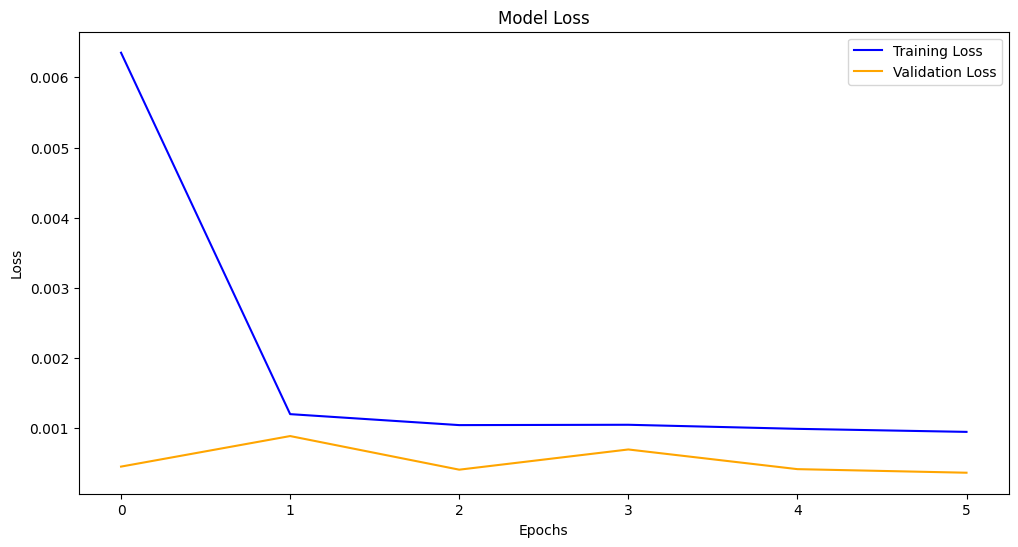

In [70]:
model = build_lstm_model((X_train.shape[1], X_train.shape[2]), CONFIG['lstm_units'], CONFIG['dropout_rate'], CONFIG['learning_rate'])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=get_callbacks(),
    verbose=1
)

plot_training_history(history)

In [71]:
train_predict = model.predict(X_train).reshape(-1, 1)
val_predict = model.predict(X_val).reshape(-1, 1)
test_predict = model.predict(X_test).reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [72]:
train_template = np.zeros((train_predict.shape[0], selected_data.shape[1]))
val_template = np.zeros((val_predict.shape[0], selected_data.shape[1]))
test_template = np.zeros((test_predict.shape[0], selected_data.shape[1]))
y_train_template = np.zeros((y_train.shape[0], selected_data.shape[1]))
y_test_template = np.zeros((y_test.shape[0], selected_data.shape[1]))

train_template[:, -1] = train_predict.flatten()
val_template[:, -1] = val_predict.flatten()
test_template[:, -1] = test_predict.flatten()
y_train_template[:, -1] = y_train.flatten()
y_test_template[:, -1] = y_test.flatten()

In [73]:
train_predict_inversed = scaler.inverse_transform(train_template)[:, -1]
val_predict_inversed = scaler.inverse_transform(val_template)[:, -1]
test_predict_inversed = scaler.inverse_transform(test_template)[:, -1]
actual_inversed = scaler.inverse_transform(scaled_data)[:, -1]
y_train_inversed = scaler.inverse_transform(y_train_template)[:, -1]
y_test_inversed = scaler.inverse_transform(y_test_template)[:, -1]

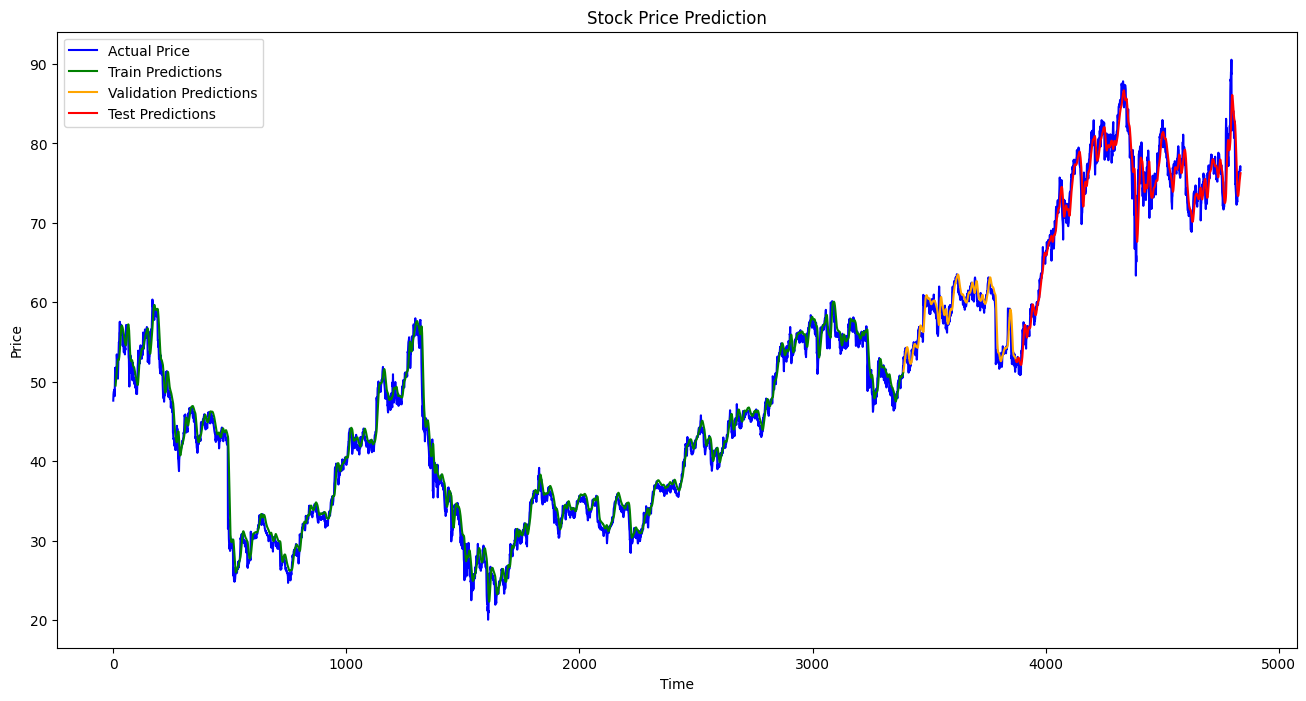

In [74]:
plot_predictions(
    actual_inversed.reshape(-1, 1),
    train_predict_inversed.reshape(-1, 1),
    val_predict_inversed.reshape(-1, 1),
    test_predict_inversed.reshape(-1, 1),
    CONFIG['time_step']
)

In [75]:
train_rmse = np.sqrt(mean_squared_error(y_train_inversed, train_predict_inversed))
train_mae = mean_absolute_error(y_train_inversed, train_predict_inversed)
train_mape = mean_absolute_percentage_error(y_train_inversed, train_predict_inversed)

test_rmse = np.sqrt(mean_squared_error(y_test_inversed, test_predict_inversed))
test_mae = mean_absolute_error(y_test_inversed, test_predict_inversed)
test_mape = mean_absolute_percentage_error(y_test_inversed, test_predict_inversed)

print(f'Training RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, MAPE: {train_mape:.4f}')
print(f'Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MAPE: {test_mape:.4f}')

Training RMSE: 1.4190, MAE: 1.0028, MAPE: 0.0261
Test RMSE: 2.0632, MAE: 1.5492, MAPE: 0.0209
